In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pandas as pd
import FinanceDataReader as fdr


from IPython.display import set_matplotlib_formats
import matplotlib as mpl
mpl.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
mpl.rc('axes',unicode_minus = False)
from PIL import Image
from collections import Counter
from wordcloud import WordCloud
from ekonlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
mecab = Mecab()


import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from nltk.tokenize import sent_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import TFGPT2LMHeadModel


from sklearn.model_selection import train_test_split
from transformers import TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [2]:
path = '/Users/ps712/OneDrive/ps/aibi/snsstock/'
path2='/Users/ps712/OneDrive/ps/aibi/snsstock/newsdata/'
list_name = 'stock.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목,종목코드
0,삼성전자,005930
1,카카오,035720
2,위메이드,112040
3,현대차,005380
4,SK하이닉스,000660
5,카카오뱅크,323410
6,한국조선해양,009540
7,ARIRANG 고배당주,161510
8,NAVER,035420
9,셀트리온,068270


In [3]:
stockcode = stock_list.loc[3,'종목코드']
news= pd.read_csv(os.path.join(path2,stockcode))
print(len(news))

13404


In [4]:
news['날짜'] = pd.to_datetime(news['날짜'])
news['year'] =news['날짜'].dt.year
news['month'] =news['날짜'].dt.month
news['day'] =news['날짜'].dt.day
news['time'] =news['날짜'].dt.time
news['date'] =news['날짜'].dt.date
news['hour'] =news['날짜'].dt.hour
news['week_day'] =news['날짜'].dt.day_name()
news['week_day_num'] =news['날짜'].dt.dayofweek
news.drop(['Unnamed: 0'],axis=1,inplace=True)
mask=news['hour']<=15 #16시 이전 뉴스만 추출
dayofend=[5,6]
weekends= news.query('week_day_num in @dayofend')
weekday= news.query('week_day_num not in @dayofend')
news = weekday.loc[mask]
news = news.loc[news['year']==2021]
news.index = pd.to_datetime(news['date'])

In [5]:
news.drop(['week_day_num'],axis=1,inplace=True)

print(len(news))

10587


In [6]:
news.drop_duplicates(subset=['기사제목'],inplace=True)
print(len(news))

2542


In [7]:
news

,날짜,언론사,기사제목,링크,year,month,day,time,date,hour,week_day
date,,,,,,,,,,,
2021-12-31,2021-12-31 14:41:00,이코노미스트,"현대차, 용산에 미래사업 R&D 거점 연구소 만든다",https://finance.naver.com/item/news_read.naver...,2021,12,31,14:41:00,2021-12-31,14,Friday
2021-12-31,2021-12-31 11:20:00,아시아경제,"현대차 원효로 사옥 재개발 탄력, UAM 중심지 된다",https://finance.naver.com/item/news_read.naver...,2021,12,31,11:20:00,2021-12-31,11,Friday
2021-12-31,2021-12-31 11:56:00,이코노미스트,"현대차, 중고차 시장 진출 가시화 하나…중기부 ""다음달 심의위 개최""",https://finance.naver.com/item/news_read.naver...,2021,12,31,11:56:00,2021-12-31,11,Friday
2021-12-31,2021-12-31 11:22:00,이코노미스트,"용산 현대차 서비스 센터 부지, ‘미래형 연구소’로 탈바꿈 예정",https://finance.naver.com/item/news_read.naver...,2021,12,31,11:22:00,2021-12-31,11,Friday
2021-12-31,2021-12-31 10:52:00,파이낸셜뉴스,용산에 현대차 미래형 연구소 조성… 서울시 지구단위계획 가결,https://finance.naver.com/item/news_read.naver...,2021,12,31,10:52:00,2021-12-31,10,Friday
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,2021-05-24 11:17:00,서울경제,"[주식 초고수는 지금] HMM, 여전한 최다 매수·매도...현대차·통신...",https://finance.naver.com/item/news_read.naver...,2021,5,24,11:17:00,2021-05-24,11,Monday
2021-05-24,2021-05-24 10:23:00,서울경제,"IBK투자증권, 현대차 목표가 13%↑...""전기차 브랜드 전환 본격화...",https://finance.naver.com/item/news_read.naver...,2021,5,24,10:23:00,2021-05-24,10,Monday
2021-05-24,2021-05-24 09:28:00,파이낸셜뉴스,"[공시]일승, 현대신텍과 16.7억원 공사계약 체결",https://finance.naver.com/item/news_read.naver...,2021,5,24,09:28:00,2021-05-24,9,Monday


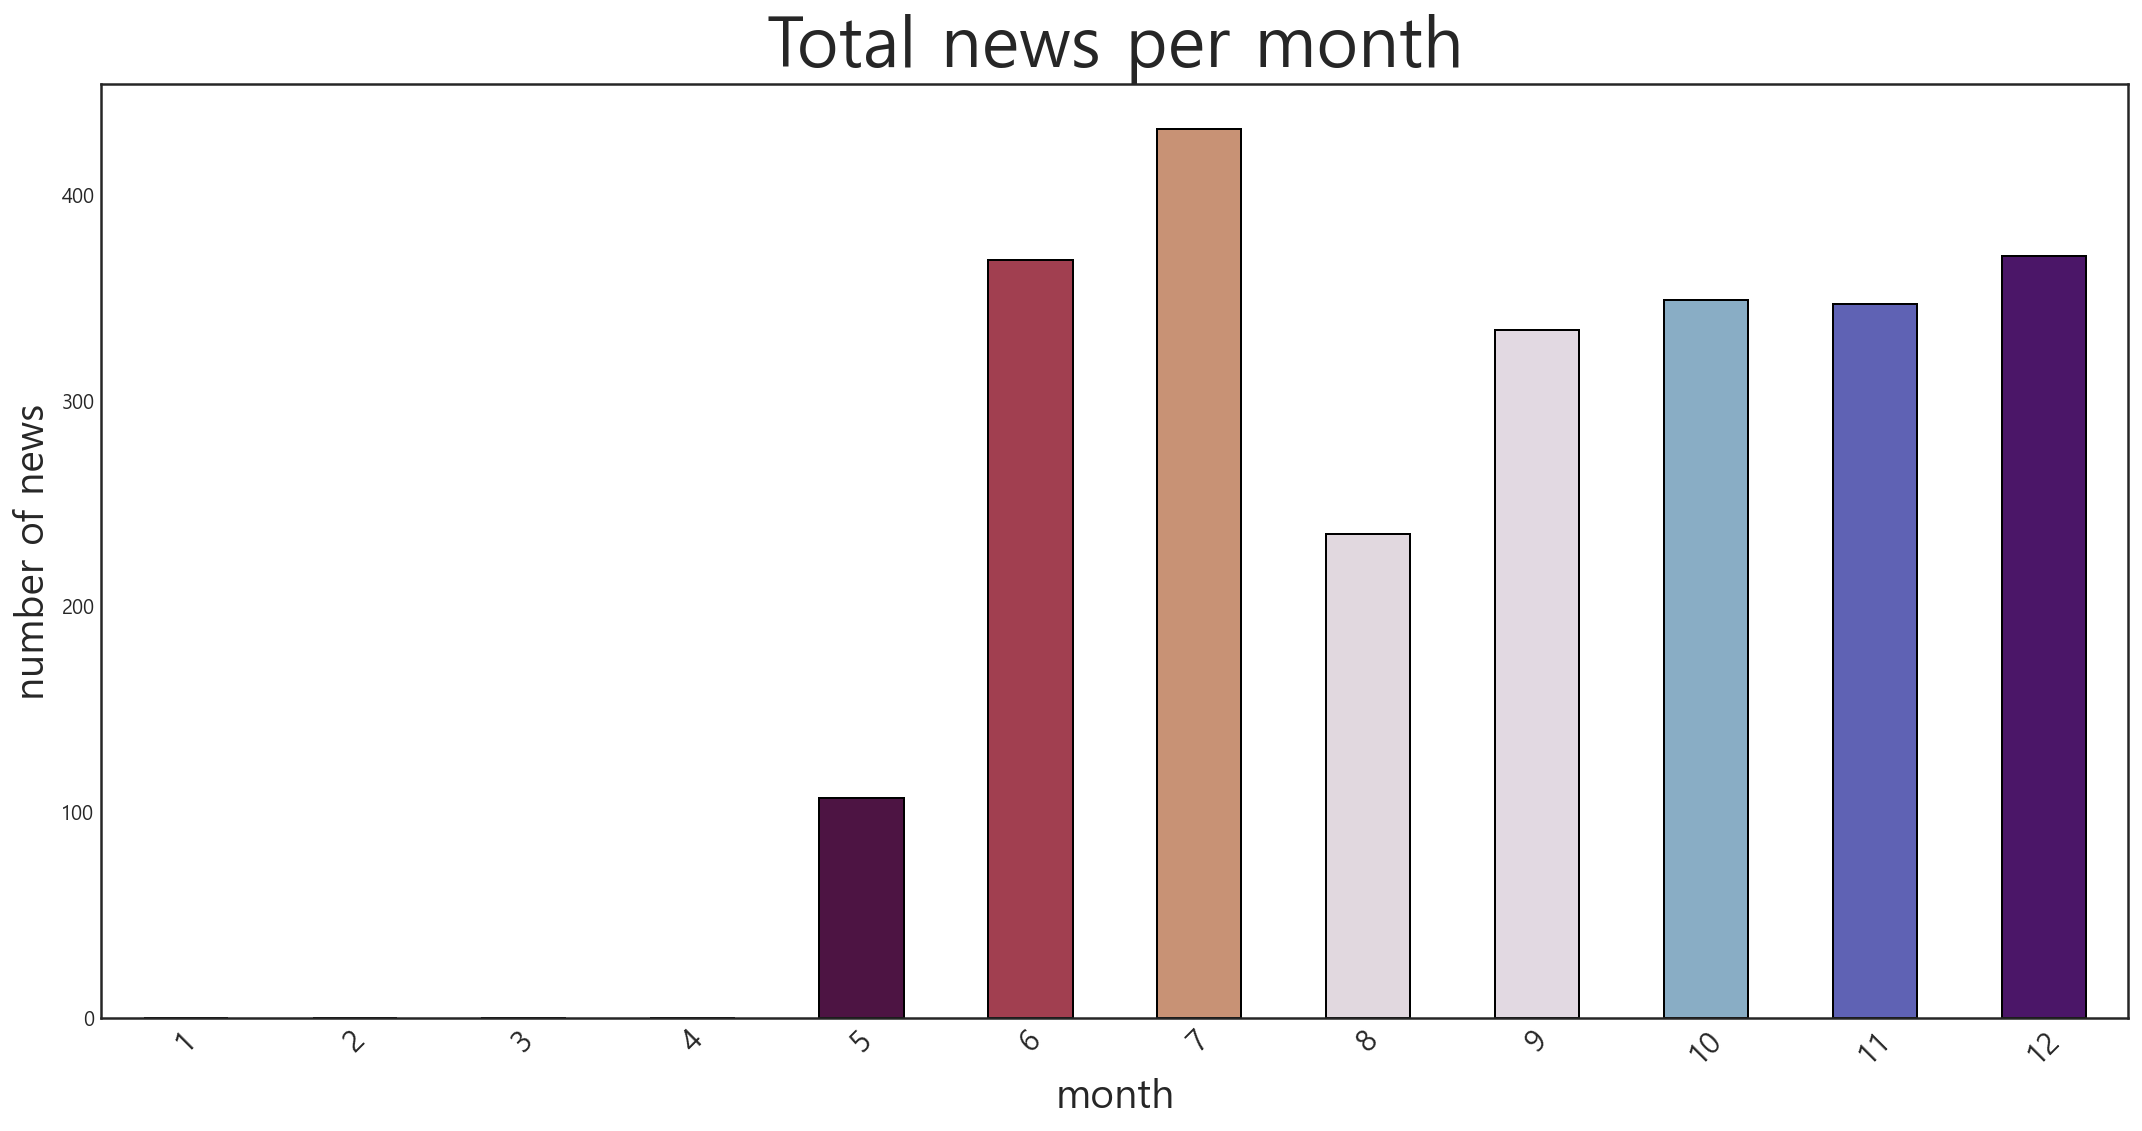

In [8]:
month_table = news['month'].value_counts()
month_table = month_table.reindex([1,2,3,4,5,6,7,8, 9, 10, 11, 12])
color_map = plt.get_cmap('twilight')
color_list = [color_map.colors[i] for i in range(0, 512, 72)]
month_table.plot(kind='bar',x='month',y='count',figsize=(15,8),edgecolor='black', color=color_list)
plt.xticks(rotation=45, fontsize=15)
plt.title('Total news per month', fontsize=35)
plt.xlabel('month', fontsize=20)
plt.ylabel('number of news', fontsize=20)
plt.tight_layout()
plt.show()

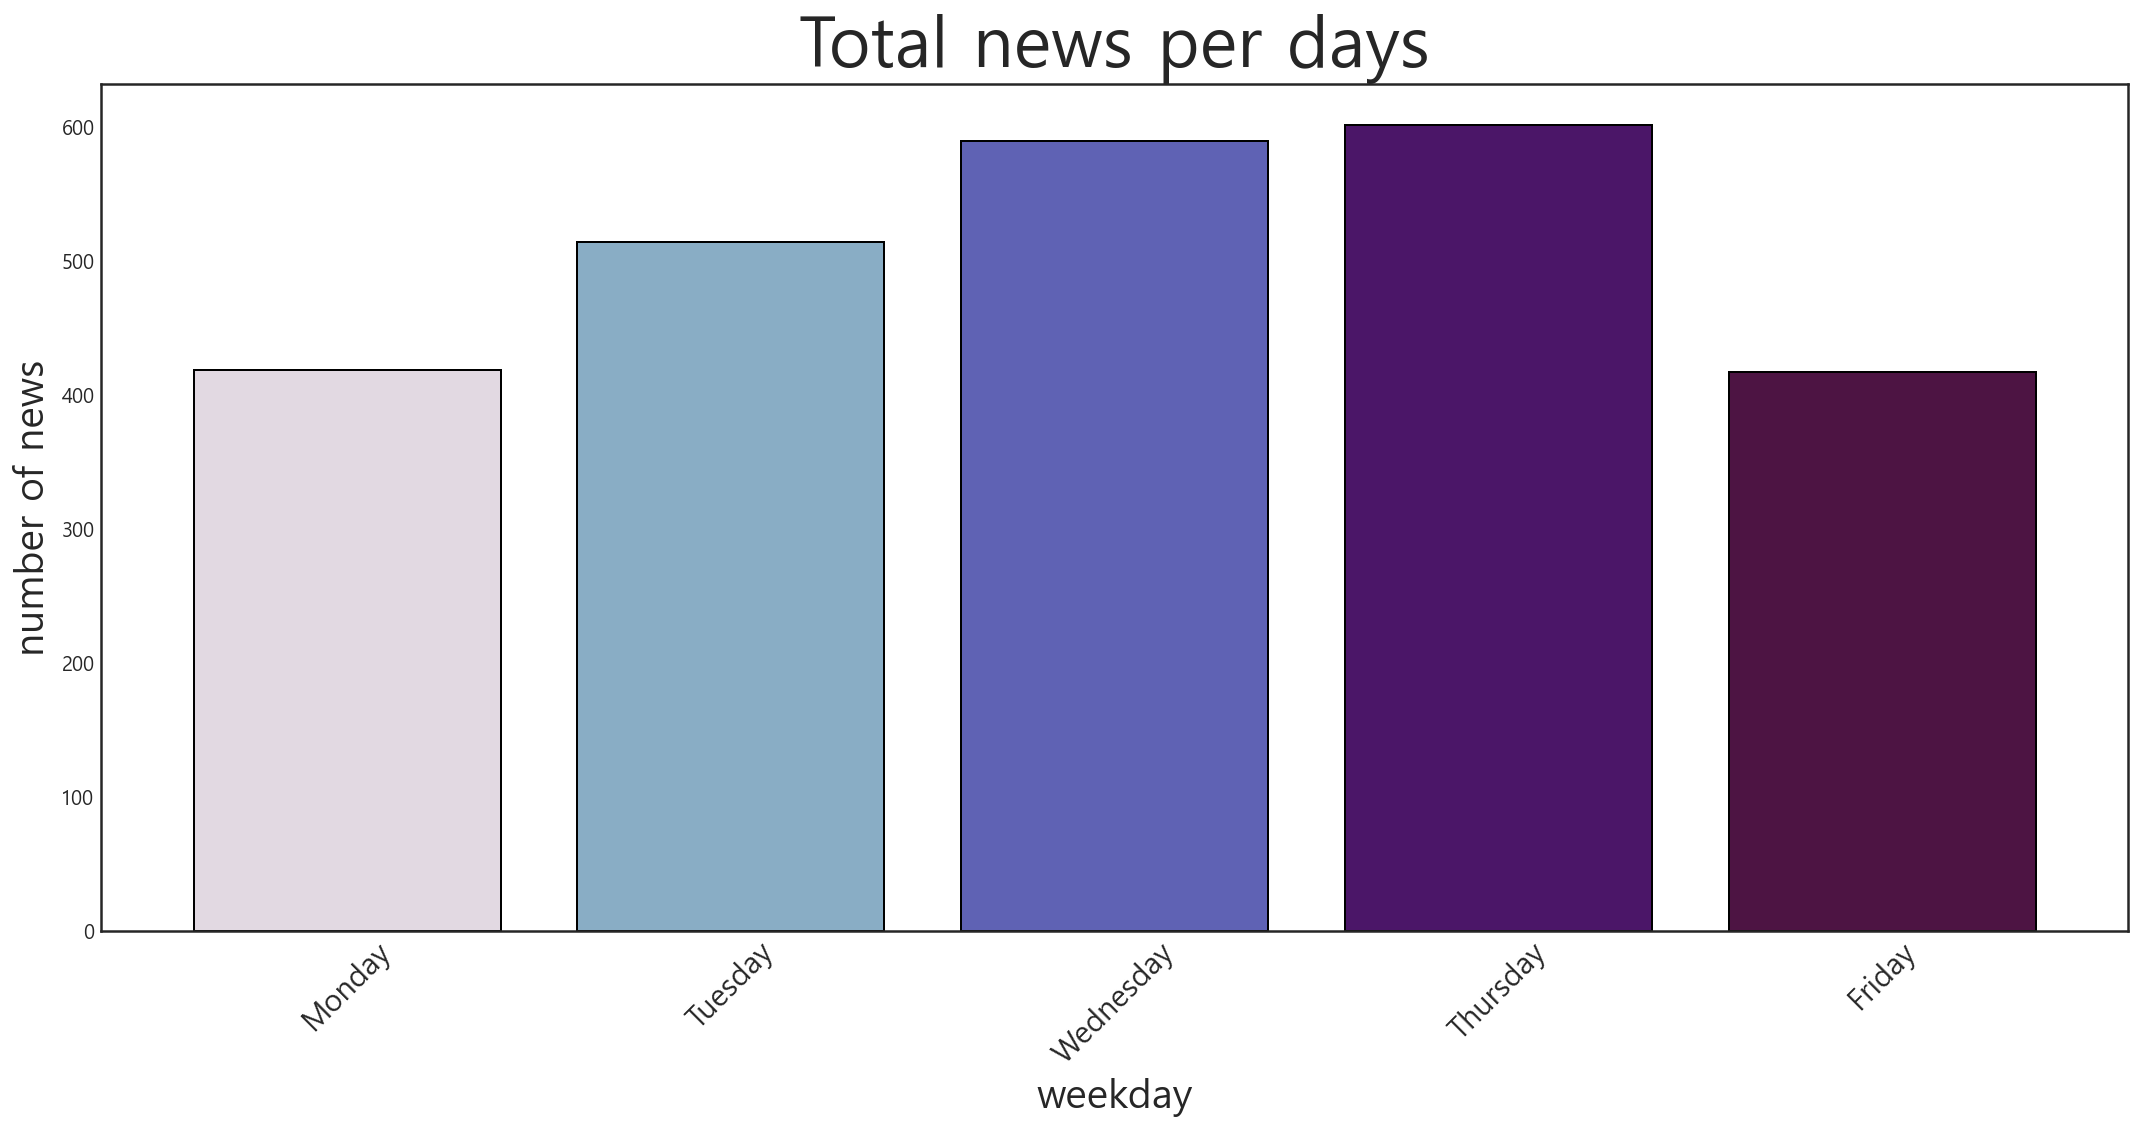

In [9]:
day_table = news['week_day'].value_counts()
day_table = day_table.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(15, 8))
color_map = plt.get_cmap('twilight')
color_list = [color_map.colors[i] for i in range(0, 512, 72)]
plt.bar(day_table.index, day_table, edgecolor='black', color=color_list)
plt.xticks(rotation=45, fontsize=15)
plt.title('Total news per days', fontsize=35)
plt.xlabel('weekday', fontsize=20)
plt.ylabel('number of news', fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
start_date = str(int(news[-1:]['날짜'].dt.strftime('%Y%m%d')))
end_date = str(int(news[0:1]['날짜'].dt.strftime('%Y%m%d')))
stock = fdr.DataReader(stockcode, start = start_date, end = end_date)
stock['up_down'] = np.where(stock['Change']>0, 1, 0)

In [11]:
news = pd.merge(news,stock['up_down'],left_index=True,right_index=True)

In [12]:
analysis = news[['기사제목','up_down']]
analysis

,기사제목,up_down
2021-05-24,"현대차·기아, 지난해 특허 3,100여 건 출원했다",1
2021-05-24,"현대차·기아, `UAM 디자인` 등 사내 우수 특허 포상",1
2021-05-24,"현대차·기아, 2021 '발명의 날' 개최",1
2021-05-24,"현대모비스, 모듈생산 가동 중단…""현대차 아산공장 생산중단 여파""",1
2021-05-24,반도체 부족에…현대차·현대모비스 아산공장 24~26일 생산중단 [주목 ...,1
...,...,...
2021-12-30,"中, 구글 등과 자율주행 합작…현대차에 악재되나 [비즈360]",0
2021-12-30,"현대차, 세계 최초 '수소 청소트럭' 공개",0
2021-12-30,오염물질 제로 '수소청소트럭' 영웅된 사연은..현대차 세계 첫 공개,0
2021-12-30,"수소청소트럭이 바꾼 환경미화원의 삶...현대차, 영상공개",0


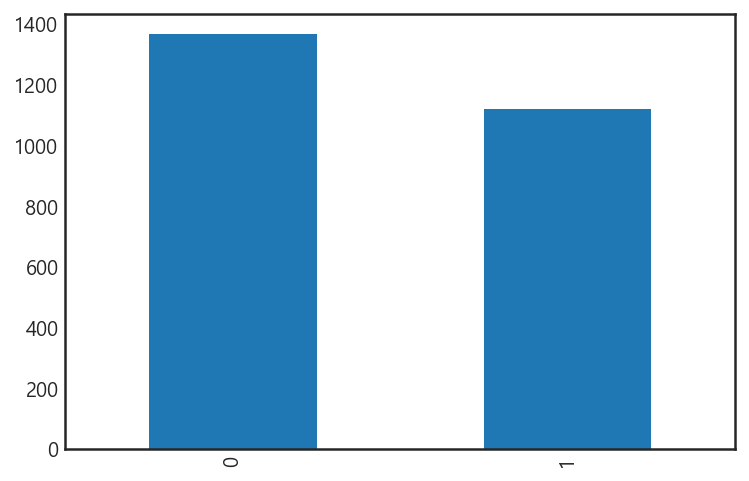

In [13]:
news['up_down'].value_counts().plot(kind='bar');#상승 하락 비슷하게 있음

In [14]:
up = news.loc[news['up_down']==1]['기사제목'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
down = news.loc[news['up_down']==0]['기사제목'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")

In [15]:
stop_words = ['현대','현대차','현대차그룹','기아','억','용','화','나','하','위','주','어','월','등','일','고','개','대','서','원','년','만','로','의','개사','했','다','한다','았','다','건','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
up_noun = []
for sentence in up:
    #불용어제외하고 mecab형태소분석기에 넣어줌
    up_noun.append([word for word in mecab.morphs(sentence) if not word in stop_words])

up_noun = [item for sublist in up_noun for item in sublist]           


In [16]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(up_noun)

threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0 
rara_freq = 0

for key, value in tokenizer.word_counts.items():
    words_freq = words_freq + value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq = rara_freq + value
        
print("전체 단어 수: ", words_cnt)
print("빈도가 {} 이하인 희귀 단어수 : {}".format(threshold-1, rare_cnt))
print("희귀단어비율 :{}".format((rare_cnt /words_cnt)*100))
print("희귀단어 등장빈도비율:{}".format((rare_freq / words_freq)*100))

전체 단어 수:  2359
빈도가 2 이하인 희귀 단어수 : 1566
희귀단어비율 :66.38406104281475
희귀단어 등장빈도비율:0.012521913348359628


In [17]:
nouns_counter = Counter(up_noun)
top_nouns = dict(nouns_counter.most_common(50))
top_nouns

{'전기차': 88,
 '수소': 80,
 '판매': 68,
 '반도체': 66,
 '공장': 57,
 '차': 54,
 '분기': 50,
 '공개': 49,
 '모빌리티': 46,
 '기술': 43,
 '생산': 40,
 '미래': 39,
 '첫': 38,
 '전기': 34,
 '자동차': 29,
 '만대': 29,
 '협력사': 29,
 '노조': 29,
 '배터리': 29,
 '차량': 28,
 '전년': 27,
 '개최': 26,
 '삼성': 26,
 '공급': 26,
 '시장': 25,
 '특징': 24,
 '올해': 24,
 '중단': 23,
 '지원': 23,
 '진출': 23,
 '아산': 22,
 '현대자동차': 22,
 '아이오닉': 22,
 '트럭': 22,
 '로봇': 22,
 '캐스퍼': 22,
 '충전': 21,
 '카': 21,
 '코로나': 21,
 '영업익': 21,
 '조억': 21,
 '투자': 20,
 '정의선': 20,
 '연속': 20,
 '캠페인': 20,
 '세계': 20,
 '비전': 20,
 '출시': 20,
 '어린이': 19,
 '최대': 19}

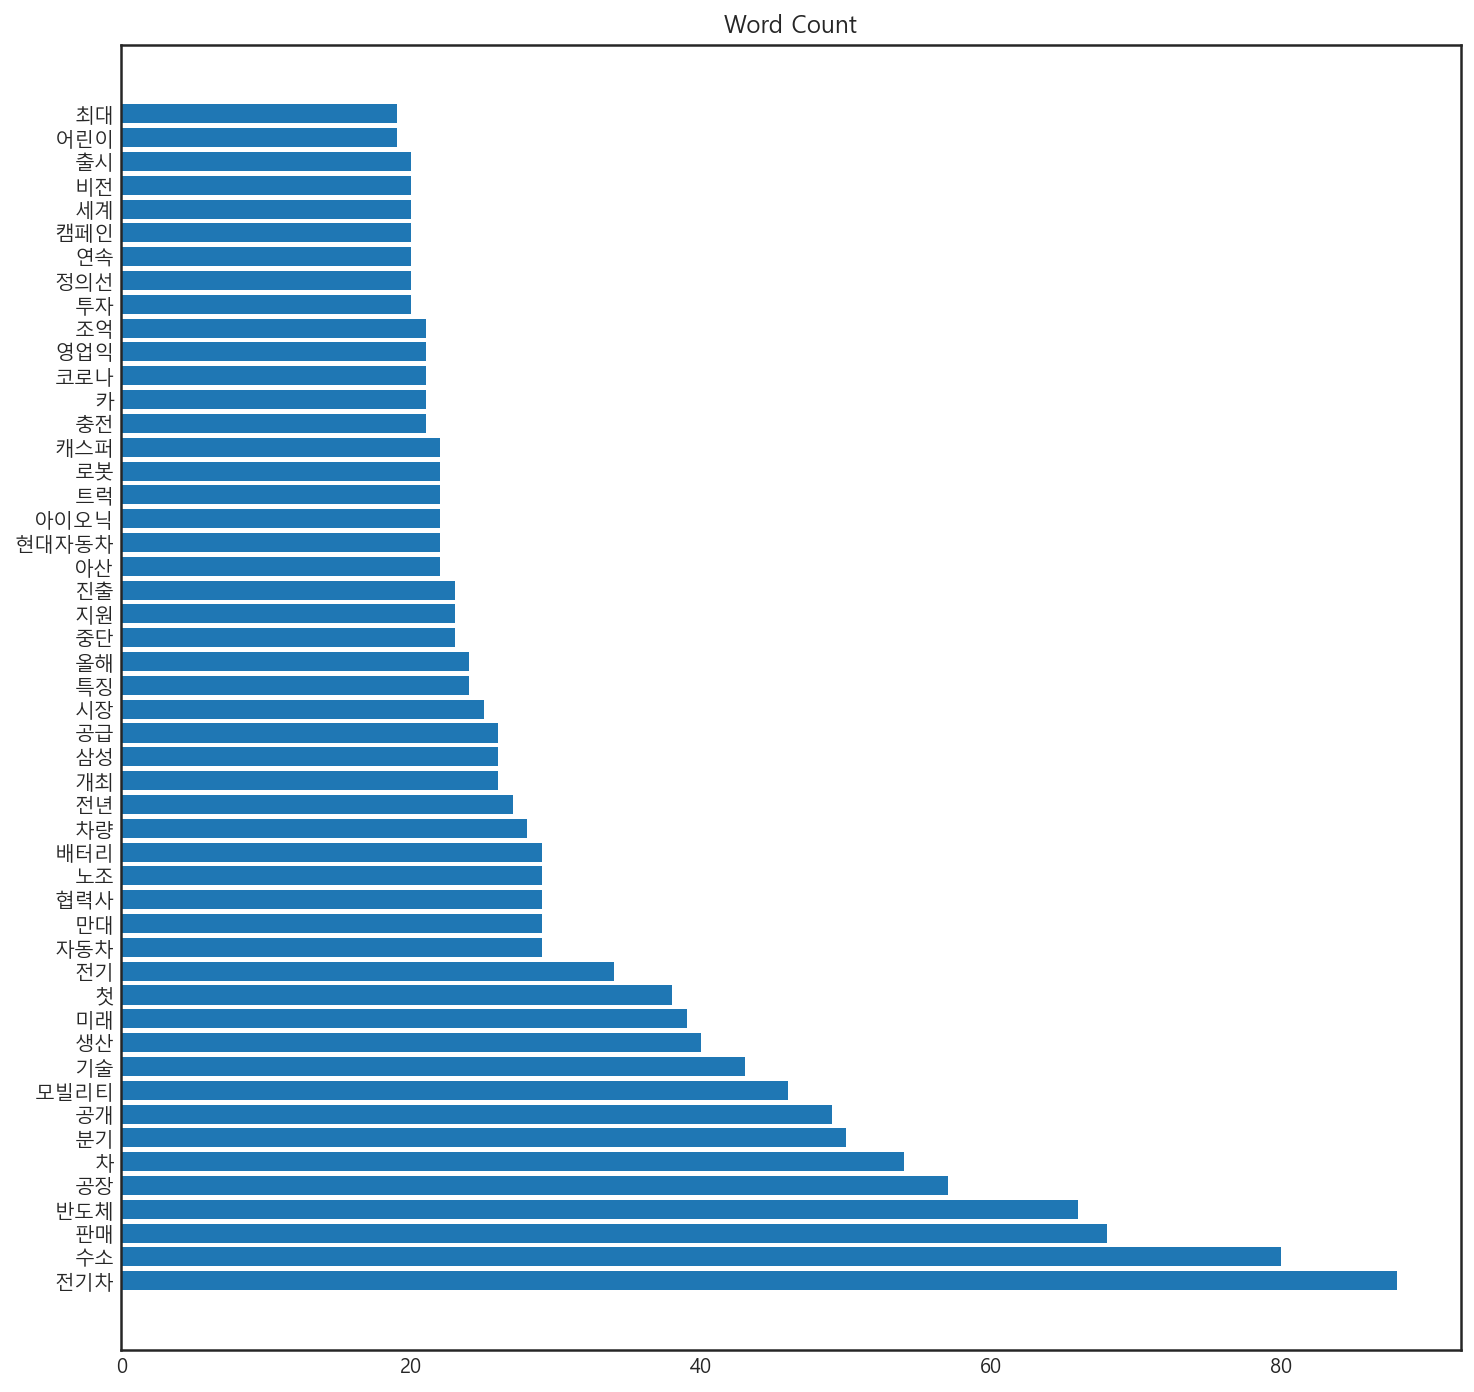

In [18]:
y_pos = np.arange(len(top_nouns))

plt.figure(figsize=(12, 12))
plt.barh(y_pos, top_nouns.values())
plt.title('Word Count')
plt.yticks(y_pos, top_nouns.keys())
plt.show()

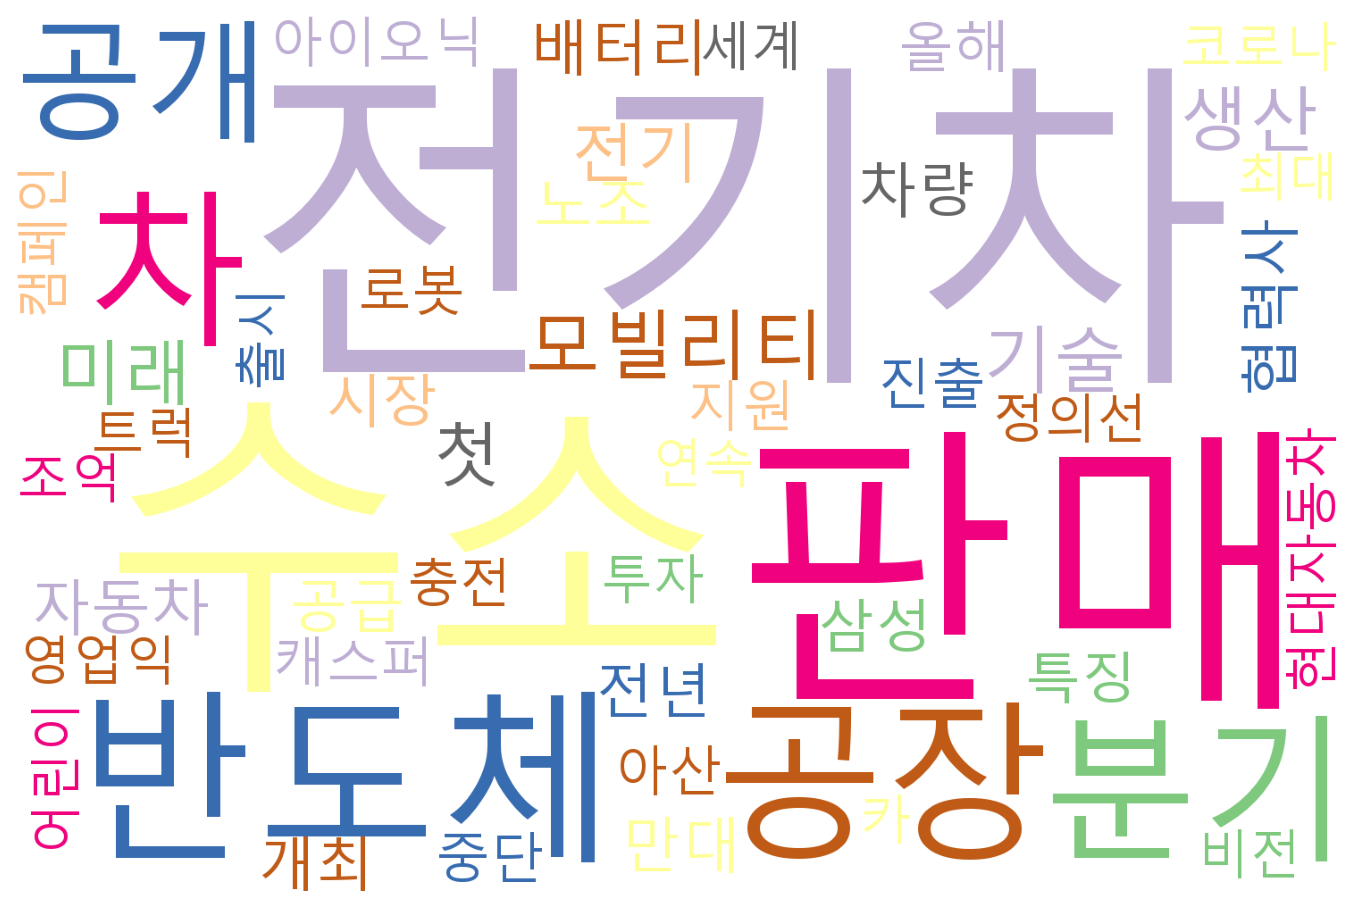

In [19]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", width=1500, height=1000)
wordcloud.generate_from_frequencies(top_nouns)

figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1, 1, 1)
ax.axis('off')
ax.imshow(wordcloud)
plt.show()


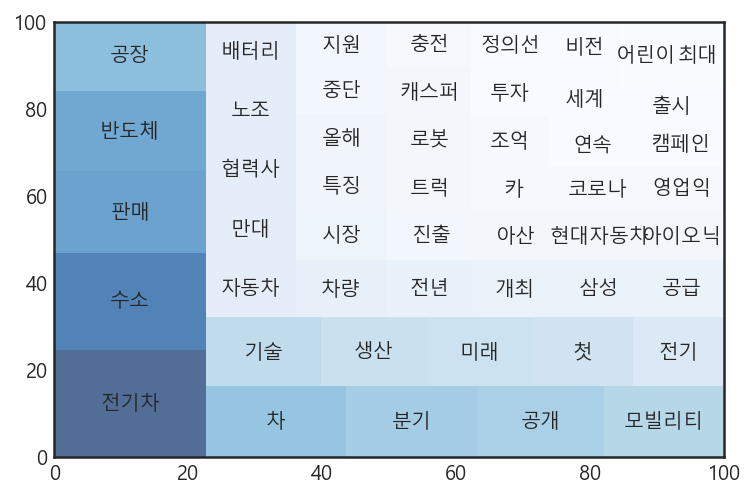

In [20]:
import squarify

norm = mpl.colors.Normalize(vmin=min(top_nouns.values()),
                            vmax=max(top_nouns.values()))

#top nouns의 값을 value로 가져와서 정규화
colors = [mpl.cm.Blues(norm(value)) for value in top_nouns.values()]

squarify.plot(label = top_nouns.keys(),
              sizes = top_nouns.values(),
              color=colors,
              alpha=0.7);

In [21]:
class GPT2Model(tf.keras.Model):
    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)
        
    def call(self, inputs):
        return self.gpt2(inputs)[0]

In [22]:
#BASE_MODEL_PATH = './gpt_ckpt'
BASE_MODEL_PATH= '/nlp/gpt_ckpt/'
gpt_model = GPT2Model(BASE_MODEL_PATH)

In [23]:
tf.random.set_seed(111)
np.random.seed(111)

In [24]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39

In [25]:
TOKENIZER_PATH = '/nlp/gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = '<unused0>',
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')

In [26]:
def clean_text(text):
    text_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)
    
    return text_clean

In [27]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=99999):
    _logits = logits.numpy()
    top_k = min(top_k, logits.shape[-1])
    if top_k > 0:
        indices_to_remove = logits < tf.math_top_k(logits, top_k)[0][..., -1, None]
        _logits[indices_to_remove] = filter_value
        
    if top_p > 0:
        sorted_logits = tf.sort(logits, direction='DESCENDING')
        sorted_indices = tf.argsort(logits, direction='DESCENDING')
        cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis= -1)
        
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
        indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()
        
        _logits[indices_to_remove] = filter_value
        
    return tf.constant([_logits])

def generate_sentence(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0.):
    sentence = seed_word
    toked = tokenizer(sentence)
    
    for _ in range(max_step):
        input_ids = tf.constant([vocab[vocab.bos_token], ] + vocab[toked])[None, :]
        outputs = model(input_ids)[:, -1, :]
        if greedy:
            gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
        else:
            output_logit =tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
            gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
        if gen == '</s>':
            break
            
        sentence += gen.replace('▁', ' ')
        toked = tokenizer(sentence)
        
    return sentence

In [28]:
train_data, test_data = train_test_split(analysis, test_size=0.25, shuffle=True)

In [29]:
train_data

,기사제목,up_down
2021-05-26,현대차도 열중하는 차세대 배터리 기술 개발,0
2021-09-01,"현대차그룹, 美 JD파워 차급별 1위 최다 기록",1
2021-12-17,[프로필]이상엽 현대자동차 부사장,0
2021-06-14,10년 뒤 60배 시장…현대차도 주목한 일진 20년 수소 노하우,0
2021-06-24,[특징주]'현대차 관련주' 화신 강세,0
...,...,...
2021-06-01,"현대차, 5월 전세계 32만3129대 판매···내수는 12% 감소",1
2021-07-14,"현대차, '아반떼 N' 세계 첫 공개...고성능 N라인 확장",0
2021-05-28,'반도체 대란' 車공장 다시 돌아간다…현대차 등 강세,1
2021-07-19,"현대자동차·기아, R&D 총력…미래차 전력 키운다",0


In [30]:
train_data_sents = []
train_data_labels= []

for train_sent, train_label in train_data[['기사제목', 'up_down']].values:
    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]
    
    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([train_tokenized_text],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens += [vocab[vocab.eos_token]]
    
    train_data_sents.append(tokens)
    train_data_labels.append(train_label)
    
train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)


In [31]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class,
                                                kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range),
                                                name='classifier')
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:,-1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

In [32]:
BASE_MODEL_PATH= '/nlp/gpt_ckpt/'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [34]:
model_name= 'tf2_gpt2_naver_stock'
DATA_OUT_PATH = './data_out'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta= 0.0001, patience=2)
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} directory already exists\n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} directory create completed\n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path,
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only= True,
                              save_weights_only=True)
history = cls_model.fit(train_data_sents, train_data_labels,
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT,
                        callbacks=[es_callback, cp_callback])

./data_out\tf2_gpt2_naver_stock directory already exists

Epoch 1/20
52/53 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.5325
Epoch 00001: val_accuracy improved from -inf to 0.48663, saving model to ./data_out\tf2_gpt2_naver_stock\weights.h5
53/53 [==============================] - 14s 102ms/step - loss: 0.6898 - accuracy: 0.5334 - val_loss: 0.7039 - val_accuracy: 0.4866
Epoch 2/20
52/53 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.5469
Epoch 00002: val_accuracy did not improve from 0.48663
53/53 [==============================] - 4s 70ms/step - loss: 0.6887 - accuracy: 0.5477 - val_loss: 0.7006 - val_accuracy: 0.4866
Epoch 3/20
52/53 [============================>.] - ETA: 0s - loss: 0.6800 - accuracy: 0.5487
Epoch 00003: val_accuracy improved from 0.48663 to 0.50267, saving model to ./data_out\tf2_gpt2_naver_stock\weights.h5
53/53 [==============================] - 4s 78ms/step - loss: 0.6800 - accuracy: 0.5489 - val_loss: 0.6876 -

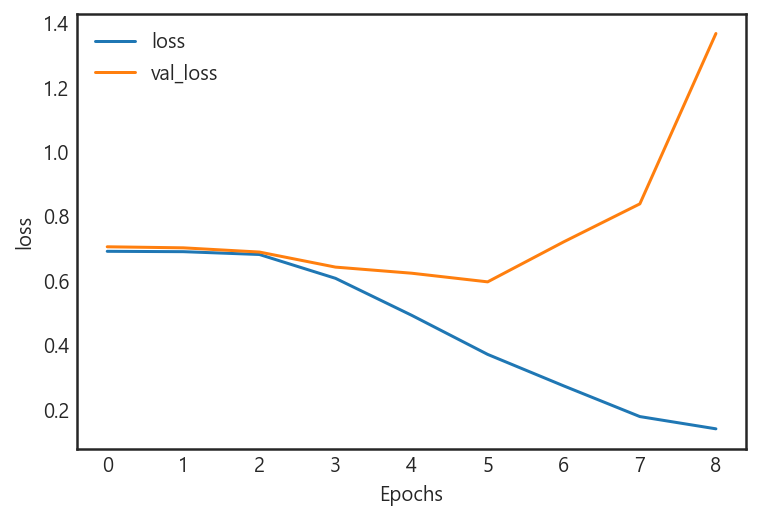

In [35]:
def plot_graphs_loss(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs_loss(history,'loss')

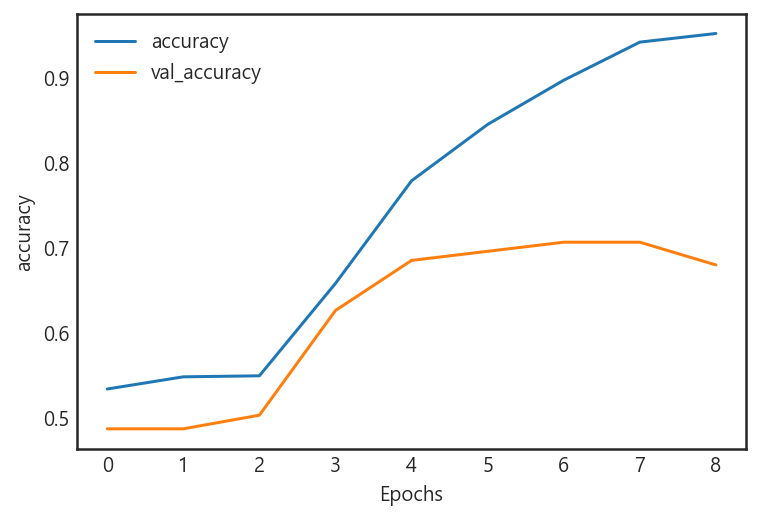

In [36]:
def plot_graphs_acc(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs_acc(history,'accuracy')

In [37]:
test_data_sents = []
test_data_labels= []

for test_sent, test_label in test_data[['기사제목', 'up_down']].values:
    test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]
    
    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([test_tokenized_text],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens += [vocab[vocab.eos_token]]
    
    test_data_sents.append(tokens)
    test_data_labels.append(test_label)
    
test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [38]:
cls_model.load_weights(checkpoint_path)
cls_model.evaluate(test_data_sents,test_data_labels, batch_size=32)

20/20 [==============================] - 0s 21ms/step - loss: 0.7247 - accuracy: 0.7134


[0.7246856689453125, 0.7133655548095703]